#Author= Michele Russo

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install maven
!mvn install -DskipTests
!pip install lenskit

/bin/bash: line 1: mvn: command not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 5.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from lenskit.algorithms import basic, item_knn, user_knn, als, funksvd
import numpy as np
import matplotlib.pyplot as plt
from lenskit import batch, topn, util
from lenskit.crossfold import partition_users
from lenskit.metrics.topn import ndcg
from lenskit import crossfold as xf
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn
from lenskit import topn
from lenskit import Predictor

#Programming Task

In [ ]:
#Load datasets

def load_data(file_path,columns):
    # Load the data into a DataFrame
    ratings_df = pd.read_csv(file_path, sep='\t', names=columns,encoding='ISO-8859-1')

    return ratings_df


##4.1 Algorithms

In [ ]:
# Given the algorithm name, this function returns the corresponding LensKit algorithm object.
#it uses Fallback in case the algorithm is not able to make a prediction for that given algorithm
#the fallback calls the algorithm basic.Bias

def lenskit_algorithm(algo_name):

    # Initialize algo variable to None
    algo = None

    # Check the algorithm name and assign the corresponding LensKit algorithm object to algo
    if algo_name == 'bias':
        algo = basic.Fallback(basic.Bias(damping=5), basic.Bias())
    elif algo_name == 'item_knn':
        algo = basic.Fallback(item_knn.ItemItem(nnbrs=20), basic.Bias())
    elif algo_name == 'user_knn':
        algo = basic.Fallback(user_knn.UserUser(nnbrs=20), basic.Bias())
    elif algo_name == 'biased_mf':
        algo = basic.Fallback(als.BiasedMF(features=50), basic.Bias())
    elif algo_name == 'implicit_mf':
        algo = basic.Fallback(als.ImplicitMF(features=50), basic.Bias())
    elif algo_name == 'funk_svd':
        algo = basic.Fallback(funksvd.FunkSVD(features=50), basic.Bias())
    else:
        # Raise ValueError if the algorithm name is invalid
        raise ValueError("Invalid algorithm name. Supported options: 'bias', 'item_knn', 'user_knn', 'biased_mf', 'implicit_mf', 'funk_svd'.")

    # Return the algo object
    return algo


##4.2

In [ ]:
# The `eval` function evaluates the performance of a recommender algorithm.
# It trains the algorithm on the training data, generates recommendations for test users,
#It then the recommendations with appended algorithm names.

def eval(aname, algo, train, test):
    # Clone the algorithm to ensure it doesn't modify the original
    fittable = util.clone(algo)
    # Adapt the algorithm to make it fittable
    fittable = Recommender.adapt(fittable)
    # Fit the algorithm on the training data
    fittable.fit(train)
    # Get unique users from the test data
    users = test.user.unique()
    # Generate recommendations for the test users
    recs = batch.recommend(fittable, users, 100)
    # Add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

# The `evaluate_algorithm` function evaluates a list of algorithms on a ratings dataset.
# It computes NDCG scores for each algorithm and plots the average NDCG scores.

def evaluate_algorithm(algorithms, ratings_df):

    # Initialize lists to store NDCG scores and recommendations
    ndcg_scores = []
    all_recs = []
    test_data = []

    # Drop the timestamp column from the ratings dataframe
    ratings_df = ratings_df.drop(axis="columns", columns="timestamp")

    # Partition the users into training and test sets
    for train, test in xf.partition_users(ratings_df[["user", "item", "rating"]], 5, xf.SampleFrac(0.2)):
        # Append the test data to the list
        test_data.append(test)

        # Iterate over each algorithm
        for algorithm in algorithms:
            # Get the LensKit algorithm object
            algo = lenskit_algorithm(algorithm)
            # Evaluate the algorithm and append the recommendations
            all_recs.append(eval(algorithm, algo, train, test))

    # Concatenate all recommendations and test data into single dataframes
    all_recs = pd.concat(all_recs, ignore_index=True)
    test_data = pd.concat(test_data, ignore_index=True)

    # Compute NDCG scores using RecListAnalysis
    rla = topn.RecListAnalysis()
    rla.add_metric(topn.ndcg)
    results = rla.compute(all_recs, test_data)

    # Display the average NDCG scores for each algorithm
    results.groupby('Algorithm').ndcg.mean()
    # Plot the average NDCG scores
    results.groupby('Algorithm').ndcg.mean().plot.bar()


##4.3

In [ ]:
# The `predict_rating` function predicts the rating score for a specific user-item pair using the specified algorithm.
# It trains the algorithm on the ratings data, extracts ratings given by the specified user,
# and then uses the trained algorithm to predict the rating for the item.

def predict_rating(user_id, item_id, ratings_df, algorithm):

    # Train the specified algorithm
    algorithm.fit(ratings_df)

    # Extract ratings given by the specified user
    ratings_user = ratings_df[ratings_df["user"] == user_id]
    user_series = ratings_user.set_index('item')['rating']

    # Use the trained algorithm to predict the rating score for the specific user-item pair
    rating_prediction = algorithm.predict_for_user(user_id, [item_id], user_series)

    return rating_prediction


#Test

In [ ]:
#Load dataset

#define the columns
ratings_columns= ['user', 'item', 'rating', 'timestamp']
#load the dataset of ratings
ratings_matrix=load_data("u.data",ratings_columns)

#define the columns
movie_columns = ['movie_id']
movie_matrix=load_data("u.item",movie_columns)


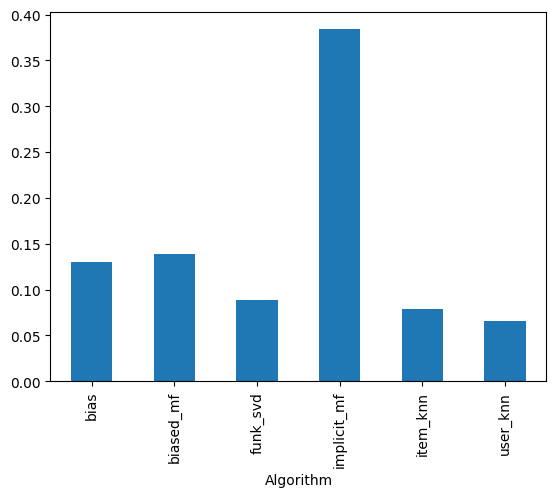

In [ ]:
#define the algorithms to be evaluated
algorithms=['bias','item_knn','user_knn','biased_mf','implicit_mf','funk_svd']
#plot the ndcg scores
ndcg_scores=evaluate_algorithm(algorithms, ratings_matrix)


In [ ]:
#predict the rating for user 196 for item 302, looking at every algorithm
user_id = 196
item_id = 302
algo_predictions=[]
for algorithm in algorithms:
  #create the algorithm
  algo=lenskit_algorithm(algorithm)
  #create the ratings
  predicted_rating = predict_rating(user_id, item_id, ratings_matrix,algo)
  algo_predictions.append((algorithm,predicted_rating))
print(algo_predictions)

[('bias', 302    4.164038
dtype: float64), ('item_knn', 302    3.804149
dtype: float64), ('user_knn', item
302    4.055305
Name: prediction, dtype: float64), ('biased_mf', 302    3.834569
dtype: float64), ('implicit_mf', 302    0.86009
dtype: float64), ('funk_svd', 302    4.189801
dtype: float64)]


In [ ]:
#run the algorithms three times and store the results
algo_predictions_new=[]
for i in range(3):
  for algorithm in algorithms:
    #create the algorithm
    algo=lenskit_algorithm(algorithm)
    #create the ratings
    predicted_rating = predict_rating(user_id, item_id, ratings_matrix,algo)
    algo_predictions_new.append((algorithm,predicted_rating,i))
print(algo_predictions_new)

[('bias', 302    4.164038
dtype: float64, 0), ('item_knn', 302    3.804149
dtype: float64, 0), ('user_knn', item
302    4.055305
Name: prediction, dtype: float64, 0), ('biased_mf', 302    3.780809
dtype: float64, 0), ('implicit_mf', 302    0.802879
dtype: float64, 0), ('funk_svd', 302    4.189379
dtype: float64, 0), ('bias', 302    4.164038
dtype: float64, 1), ('item_knn', 302    3.804149
dtype: float64, 1), ('user_knn', item
302    4.055305
Name: prediction, dtype: float64, 1), ('biased_mf', 302    3.83374
dtype: float64, 1), ('implicit_mf', 302    0.908065
dtype: float64, 1), ('funk_svd', 302    4.190119
dtype: float64, 1), ('bias', 302    4.164038
dtype: float64, 2), ('item_knn', 302    3.804149
dtype: float64, 2), ('user_knn', item
302    4.055305
Name: prediction, dtype: float64, 2), ('biased_mf', 302    3.869048
dtype: float64, 2), ('implicit_mf', 302    0.847701
dtype: float64, 2), ('funk_svd', 302    4.191732
dtype: float64, 2)]


In [ ]:
#see the error give by basic.Random
algorithm_error=basic.Random()
predicted_rating = predict_rating(user_id, item_id, ratings_matrix,algorithm_error)

AttributeError: 'Random' object has no attribute 'predict_for_user'